In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install tensorflow
import tensorflow
print(tensorflow.__version__)
#!pip install tensorflow==1.15.3

2.3.0


In [3]:
!pip install Pillow
!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 132kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [4]:
! pip install SimpleITK

     |████████████████████████████████| 44.9MB 94kB/s 


In [5]:
import SimpleITK as sitk

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

##import SimpleITK as sitk

from PIL import Image

from scipy.misc import imread

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

In [7]:
annotations = pd.read_csv('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/annotations.csv')
candidates = pd.read_csv('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/candidates.csv')

In [8]:
annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [9]:
candidates['class'].sum()

1351

In [10]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [11]:
print(len(candidates[candidates['class'] == 1]))
print(len(candidates[candidates['class'] == 0]))

1351
549714


In [12]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print(num_cores)

2


In [13]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/seg-lungs-LUNA16/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)

In [14]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

In [15]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [16]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

In [17]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [18]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [19]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [20]:
from sklearn.model_selection import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [21]:
X_train.size

25936

In [22]:
y_train

178085    0
108126    0
416697    0
342095    0
116478    0
         ..
469116    0
164439    0
333192    1
358382    0
536292    0
Name: class, Length: 6484, dtype: int64

In [23]:
y_test

189342    0
145102    0
31546     0
441280    1
215578    0
         ..
87015     0
245189    0
533231    0
52755     0
379730    0
Name: class, Length: 1622, dtype: int64

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42)

In [25]:
X_train.size

20748

In [26]:
X_train

,seriesuid,coordX,coordY,coordZ
59270,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,-97.808167,3.897917,-201.030000
150277,1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...,58.990000,-24.230000,-18.320000
432208,1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...,-50.307219,159.439740,-113.418797
423122,1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295...,-106.731000,-104.468000,751.163333
344581,1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...,67.240000,-32.590000,-107.790000
...,...,...,...,...
323102,1.3.6.1.4.1.14519.5.2.1.6279.6001.279953669991...,-22.239361,84.653132,-161.740390
94004,1.3.6.1.4.1.14519.5.2.1.6279.6001.149893110752...,52.320000,65.000000,-117.870000
459476,1.3.6.1.4.1.14519.5.2.1.6279.6001.503980049263...,-112.420630,37.648160,-67.928064
241550,1.3.6.1.4.1.14519.5.2.1.6279.6001.230416590143...,-27.740000,-121.660000,-254.130000


In [27]:
y_train

59270     0
150277    0
432208    0
423122    0
344581    0
         ..
323102    0
94004     0
459476    1
241550    0
211695    0
Name: class, Length: 5187, dtype: int64

In [28]:
len(X_train)

5187

In [29]:
X_train.to_pickle('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/preprocessed_data/traindata')
X_test.to_pickle('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/preprocessed_data/testdata')
X_val.to_pickle('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/preprocessed_data/valdata')

In [30]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [31]:
print('number of positive cases are ' + str(y_train.sum()))
print('total set size is ' + str(len(y_train)))
print('percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train)))

number of positive cases are 845
total set size is 5187
percentage of positive cases are 0.16290726817042606


In [32]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
tempDf = tempDf.set_index(X_train[y_train == 1].index + 2000000)
X_train_new = X_train_new.append(tempDf)

ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
ytemp.loc[:] = 1
y_train_new = y_train.append(ytemp)
ytemp = y_train.reindex(X_train[y_train == 1].index + 2000000)
ytemp.loc[:] = 1
y_train_new = y_train_new.append(ytemp)

print(len(X_train_new), len(y_train_new))

6877 6877


In [33]:
X_train_new

,seriesuid,coordX,coordY,coordZ
59270,1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896...,-97.808167,3.897917,-201.030000
150277,1.3.6.1.4.1.14519.5.2.1.6279.6001.182192086929...,58.990000,-24.230000,-18.320000
432208,1.3.6.1.4.1.14519.5.2.1.6279.6001.397522780537...,-50.307219,159.439740,-113.418797
423122,1.3.6.1.4.1.14519.5.2.1.6279.6001.339882192295...,-106.731000,-104.468000,751.163333
344581,1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932...,67.240000,-32.590000,-107.790000
...,...,...,...,...
2436163,1.3.6.1.4.1.14519.5.2.1.6279.6001.404768898286...,88.955096,224.250740,-586.901865
2013078,1.3.6.1.4.1.14519.5.2.1.6279.6001.106719103982...,-57.089458,72.608061,1791.668825
2352132,1.3.6.1.4.1.14519.5.2.1.6279.6001.300246184547...,100.136716,3.904990,-93.909072
2188812,1.3.6.1.4.1.14519.5.2.1.6279.6001.202187810895...,118.180000,-42.910000,-247.440000


In [34]:
y_train_new

59270      0.0
150277     0.0
432208     0.0
423122     0.0
344581     0.0
          ... 
2436163    1.0
2013078    1.0
2352132    1.0
2188812    1.0
2459476    1.0
Name: class, Length: 6877, dtype: float64

In [35]:
X_train_new.index

Int64Index([  59270,  150277,  432208,  423122,  344581,   75111,  246217,
             292479,  147683,  468235,
            ...
            2282167, 2300642, 2021354, 2461166, 2332952, 2436163, 2013078,
            2352132, 2188812, 2459476],
           dtype='int64', length=6877)

In [36]:
import scipy.misc

In [37]:
import cv2

In [38]:
#from scipy.misc import imresize
from PIL import ImageEnhance

class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        self.image = (self.image/255.0 - 0.25)*255
        return self.image
    
    def downsample_data(self):
        self.image = cv2.resize(self.image, (40,40), interpolation = cv2.INTER_AREA)
        return self.image

    def upsample_data(self):
        self.image = cv2.resize(self.image, (224, 224), interpolation = cv2.INTER_CUBIC)
        return self.image

Imported the preprocessed and segmented dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Original shape of input image:  (50, 50)


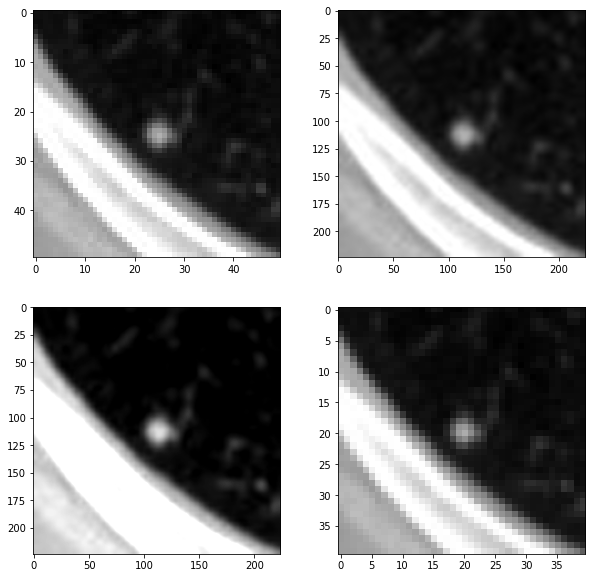

In [39]:
dirName = '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/'
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(30517) + '.jpg')
print ("Original shape of input image: ", inp.shape)
plt.subplot(221)
plt.imshow(inp, cmap='gray')
plt.grid(False)

inp = PreProcessing(inp).upsample_data()
Pp = PreProcessing(inp)

inp2 = Pp.subtract_mean()
plt.subplot(222)
plt.imshow(inp2, cmap='gray')
plt.grid(False)

inp3 = ImageEnhance.Contrast(Image.fromarray(inp))
contrast = 1.5
inp3 = inp3.enhance(contrast)
plt.subplot(223)
plt.imshow(inp3, cmap='gray')
plt.grid(False)

inp4 = Pp.downsample_data()
plt.subplot(224)
plt.imshow(inp4,cmap='gray')
plt.grid(False)


In [40]:
inp.shape

(224, 224)

In [41]:
inp.dtype

dtype('uint8')

In [42]:
#!pip install tflearn==0.3.2
#import tflearn

In [43]:
y_train_new.values.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

Training

In [44]:
dirName

'/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/'

In [45]:
train_filenames =\
X_train_new.index.to_series().apply(lambda x:\
                                    '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_'+str(x)+'.jpg')
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2459476.jpg'],
      dtype='<U80')

In [46]:
train_filenames.values.astype(str)

array(['/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_59270.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_150277.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_432208.jpg',
       ...,
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2352132.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2188812.jpg',
       '/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/train/image_2459476.jpg'],
      dtype='<U80')

In [47]:
#@title Default title text
dataset_file = 'traindatalabels.txt'
filenames = train_filenames.values.astype(str)
train_filenames =X_train_new.index.to_series().apply(lambda x:filenames)
labels = y_train_new.values.astype(int)
traindata = np.zeros(filenames.size,\
                     dtype=[('var1', 'S36'), ('var2', int)])
traindata['var1'] = filenames
traindata['var2'] = labels

np.savetxt(dataset_file, traindata, fmt="%10s %d")

In [48]:
traindata

array([(b'/content/gdrive/My Drive/lungcancer/', 0),
       (b'/content/gdrive/My Drive/lungcancer/', 0),
       (b'/content/gdrive/My Drive/lungcancer/', 0), ...,
       (b'/content/gdrive/My Drive/lungcancer/', 1),
       (b'/content/gdrive/My Drive/lungcancer/', 1),
       (b'/content/gdrive/My Drive/lungcancer/', 1)],
      dtype=[('var1', 'S36'), ('var2', '<i8')])

In [49]:
#import tflearn

In [50]:
# Build a HDF5 dataset (only required once)
#from tflearn.data_utils import build_hdf5_image_dataset
#build_hdf5_image_dataset(dataset_file, image_shape=(50, 50), mode='file', output_path='traindataset.h5', categorical_labels=True, normalize=True)

In [51]:
# Load HDF5 dataset
import h5py
h5f = h5py.File('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/traindataset.h5', 'r')
X_train_images = h5f['X']
Y_train_labels = h5f['Y']

h5f2 = h5py.File('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/valdataset.h5', 'r')
X_val_images = h5f2['X']
Y_val_labels = h5f2['Y']

In [52]:
X_train_images

<HDF5 dataset "X": shape (5187, 50, 50), type "<f4">

In [53]:
Y_train_labels

<HDF5 dataset "Y": shape (5187, 2), type "<f4">

Testing_image_processing

In [54]:
X_train_processing = np.array(X_train_images)
X_val_processing = np.array(X_val_images)

In [55]:
print(X_train_processing.shape)
print(X_val_processing.shape)

(5187, 50, 50)
(1297, 50, 50)


In [56]:
print(X_train_processing.dtype)
print(X_val_processing.dtype)

float32
float32


In [57]:
img_test = X_train_processing[1000]
img_test_downsampled = PreProcessing(img_test).downsample_data()
img_test_upsampled = PreProcessing(img_test).upsample_data()

In [58]:
print(Y_train_labels[1000])

[1. 0.]


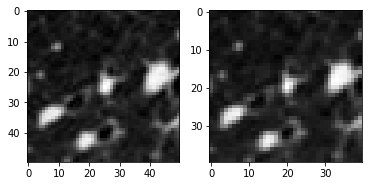

In [59]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_downsampled,cmap='gray')

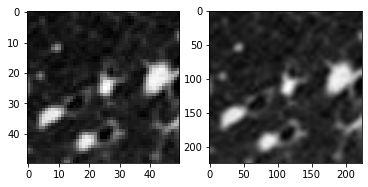

In [60]:
plt.subplot(121)
plt.imshow(img_test,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_upsampled,cmap='gray')

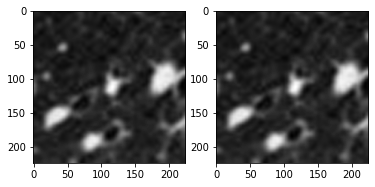

In [61]:
img_test_subtracted_mean = PreProcessing(img_test_upsampled).subtract_mean()
plt.subplot(121)
plt.imshow(img_test_upsampled,cmap='gray')
plt.subplot(122)
plt.imshow(img_test_subtracted_mean,cmap='gray')

testing cv2 BRISK algorithm

need some work and research

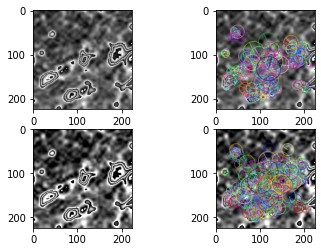

In [86]:
import cv2
brisk = cv2.BRISK_create(50)
img_BRISK_1 = img_test_upsampled.copy()
rgb = cv2.cvtColor(img_BRISK_1, cv2.COLOR_GRAY2RGB)
img_BRISK_2 = rgb*1000
img_BRISK_3 = np.array(img_BRISK_2, dtype=np.uint8)
img_contr_copy = img_BRISK_3.copy()

plt.subplot(221)
plt.imshow(img_BRISK_3, cmap='gray')
kpts_1, des_1 = brisk.detectAndCompute(img_BRISK_3, None)

image_BRISK_1 = cv2.drawKeypoints(image=img_BRISK_3, outImage=img_BRISK_3, keypoints=kpts_1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(222)
plt.imshow(image_BRISK_1, cmap='gray')


# with enhanced contrast

inp_contr = ImageEnhance.Contrast(Image.fromarray(img_contr_copy))
contrast = 1.5
img_contr = inp_contr.enhance(contrast)
plt.subplot(223)
plt.imshow(img_contr, cmap='gray')
img_BRISK_4 = np.array(img_contr)
kpts_2, des_2 = brisk.detectAndCompute(img_BRISK_4, None)

image_BRISK_2 = cv2.drawKeypoints(image=img_BRISK_4, outImage=img_BRISK_4, keypoints=kpts_2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(224)
plt.imshow(image_BRISK_2, cmap='gray')

test both with other CV2 algorithms and then implement all those algorithms with DL model self defined.

Converting to training dataset

In [63]:
X_train_images_np = np.expand_dims(np.array(X_train_images), axis = 3)
y_train_labels_np = np.array(Y_train_labels)
X_val_images_np = np.expand_dims(np.array(X_val_images), axis = 3)
y_val_labels_np = np.array(Y_val_labels)

In [64]:
print(X_train_images_np.shape)
print(y_train_labels_np.shape)
print(X_val_images_np.shape)
print(y_val_labels_np.shape)

(5187, 50, 50, 1)
(5187, 2)
(1297, 50, 50, 1)
(1297, 2)


In [65]:
print(X_train_images_np.dtype)
print(y_train_labels_np.dtype)
print(X_val_images_np.dtype)
print(y_val_labels_np.dtype)

float32
float32
float32
float32


processing for test dataset

In [67]:
h5f2 = h5py.File('/content/gdrive/My Drive/lungcancer/Dataset_LUNA_16/data/testdataset.h5', 'r')
X_test_images = h5f2['X']
Y_test_labels = h5f2['Y']

In [68]:
X_test_images_np = np.expand_dims(np.array(X_test_images), axis = 3)
y_test_labels_np = np.array(Y_test_labels)

In [69]:
print(X_test_images_np.shape)
print(y_test_labels_np.shape)

(1622, 50, 50, 1)
(1622, 2)


In [70]:
print(X_test_images_np.dtype)
print(y_test_labels_np.dtype)

float32
float32


Model Making and Model Training

In [71]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,AveragePooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

model based on deep cnn

In [72]:
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 1)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.1))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.5))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'));return model

mobile = define_model()

In [73]:
mobile.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        1

In [74]:
op_layer = mobile.output
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(op_layer)
final_layer = Dense(128,activation='relu',kernel_initializer='he_uniform')(final_layer)
final_layer = Dense(2,activation= 'softmax')(final_layer)
from keras.models  import Model
# Define model input and output
model = Model(inputs = mobile.input , outputs = final_layer)
opt = SGD(lr=0.001, momentum=0.9)
import keras
optimizer_sgd = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [75]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)       

In [76]:
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(hist):
	plt.plot(hist.history["accuracy"])
	plt.plot(hist.history['val_accuracy'])
	plt.plot(hist.history['loss'])
	plt.plot(hist.history['val_loss'])
	plt.title("model accuracy")
	plt.ylabel("Accuracy")
	plt.xlabel("Epoch")
	plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])

In [78]:
callbacks = [
    keras.callbacks.ModelCheckpoint('classification_deep_conv_model.h5', save_best_only=True),
    keras.callbacks.ReduceLROnPlateau()]

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/500
81/81 [==============================] - 3s 35ms/step - loss: 0.5176 - accuracy: 0.8157 - val_loss: 0.5193 - val_accuracy: 0.8273
Epoch 2/500
81/81 [==============================] - 2s 29ms/step - loss: 0.4680 - accuracy: 0.8302 - val_loss: 0.4418 - val_accuracy: 0.8273
Epoch 3/500
81/81 [==============================] - 2s 29ms/step - loss: 0.4398 - accuracy: 0.8358 - val_loss: 0.4369 - val_accuracy: 0.8258
Epoch 4/500
81/81 [==============================] - 2s 30ms/step - loss: 0.4225 - accuracy: 0.8349 - val_loss: 0.4200 - val_accuracy: 0.8296
Epoch 5/500
81/81 [==============================] - 2s 29ms/step - loss: 0.4222 - accuracy: 0.8345 - val_loss: 0.4054 - val_accuracy: 0.8365
Epoch 6/500
81/81 [==============================] - 2s 29ms/step - loss: 0.3921 - accuracy: 0.8372 - val_loss: 0.3676 - val_accuracy: 0.8473
Epoch 7/500
81/81 [==============================] - 2s 27ms/step - loss

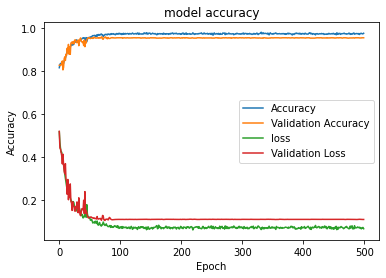

In [79]:
# run the test harness for evaluating a model
def run_test_harness():
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.1)
	# prepare iterator
	it_train = datagen.flow(X_train_images_np, y_train_labels_np, batch_size=64)
	# fit model
	steps = int(X_train_images_np.shape[0] / 64)
	hist = model.fit_generator(it_train, steps_per_epoch=steps, epochs=500, validation_data=(X_val_images_np, y_val_labels_np), verbose=1, callbacks = callbacks)
	# evaluate model
	_, acc = model.evaluate(X_val_images_np, y_val_labels_np, verbose=1)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(hist)

# entry point, run the test harness
run_test_harness()

In [81]:
model_new_1 = keras.models.load_model("classification_deep_conv_model.h5")

In [82]:
model_new_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 50, 50, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 50, 50, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)       

In [83]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = model_new_1.predict(X_test_images_np)
y_p = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test_labels_np,axis=1)
print('confusion matrix')
print(confusion_matrix(y_true,y_p))


confusion matrix
[[1312   28]
 [  41  241]]


In [84]:
print('Classification report')
print(classification_report(y_true,y_p))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1340
           1       0.90      0.85      0.87       282

    accuracy                           0.96      1622
   macro avg       0.93      0.92      0.92      1622
weighted avg       0.96      0.96      0.96      1622



In [86]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
op_layer = model_new_1.get_layer('dense_3').output
model_new = Model(inputs = model_new_1.input,outputs = op_layer)
train_new = sc.fit_transform(model_new.predict(X_train_images_np))
val_new = sc.fit_transform(model_new.predict(X_val_images_np))
test_new = sc.fit_transform(model_new.predict(X_test_images_np))

In [87]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
svm.fit(train_new,np.argmax(y_train_labels_np,axis=1))
print('Training score of svm',svm.score(train_new,np.argmax(y_train_labels_np,axis=1)))
print('validation score of svm :',svm.score(val_new,np.argmax(y_val_labels_np,axis=1)))
print('testing score of svm :',svm.score(test_new,np.argmax(y_test_labels_np,axis=1)))

Training score of svm 0.989010989010989
validation score of svm : 0.9552814186584425
testing score of svm : 0.9556103575832305


In [88]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(train_new,np.argmax(y_train_labels_np,axis=1))
print('Training score of xgb',xg.score(train_new,np.argmax(y_train_labels_np,axis=1)))
print('validation score of xgb :',xg.score(val_new,np.argmax(y_val_labels_np,axis=1)))
print('testing score of xgb :',xg.score(test_new,np.argmax(y_test_labels_np,axis=1)))

Training score of xgb 0.9901677270098322
validation score of xgb : 0.9552814186584425
testing score of xgb : 0.9549938347718866


In [89]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(train_new,np.argmax(y_train_labels_np,axis=1))
print('Training score of random_forest',rf.score(train_new,np.argmax(y_train_labels_np,axis=1)))
print('validation score of random_forest :',rf.score(val_new,np.argmax(y_val_labels_np,axis=1)))
print('testing score of random_forest :',rf.score(test_new,np.argmax(y_test_labels_np,axis=1)))

Training score of random_forest 1.0
validation score of random_forest : 0.9599074787972244
testing score of random_forest : 0.9580764488286067
